### Importar bibliotecas

In [1]:
# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
# Manipulação de dados
import pandas as pd
import numpy as np
import warnings
# Plotagem de dados
import matplotlib.pyplot as plt
# Módulos Estatísticos
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
# Métricas de Modelos e Estatísticas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats
# Modelo ARIMA e SARIMA
from pmdarima.arima import auto_arima

### Criar conexão com os dados no GCP

In [2]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

#### Criar dataframe com os dados já tratados e selecionados

In [3]:
# Os dados de mortalidade já foram tratados na ETL para calcular o YLL por cada óbito
# Aqui esta importação já está trazendo a taxa média do YLL dos municípios de médio porte por quedrimestre
consulta_sql = """
select
	tx.mes,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_mensal as (
		select
			date(extract(year from y.dt_obito), extract(month from y.dt_obito), 1) as mes,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1, 2, 3
	)
	select
		mes,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 AS taxa_yll
	from yll_mensal
    	group by 1, 2, 3, 4
) tx
group by 1
order by 1
"""

In [4]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [5]:
df.head()

,mes,taxa_media_yll
0,2010-01-01,1.812783
1,2010-02-01,1.606918
2,2010-03-01,1.615031
3,2010-04-01,1.537756
4,2010-05-01,1.668029


In [6]:
df.dtypes

mes                dbdate
taxa_media_yll    float64
dtype: object

### Cópia do DataFrame para manipulação e criação dos modelos

In [7]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [8]:
# Transformando o quadrimestre em data
time_series['mes'] = pd.to_datetime(time_series['mes'])

In [9]:
time_series.dtypes

mes               datetime64[ns]
taxa_media_yll           float64
dtype: object

In [10]:
# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('mes')

In [11]:
time_series

,taxa_media_yll
mes,
2010-01-01,1.812783
2010-02-01,1.606918
2010-03-01,1.615031
2010-04-01,1.537756
2010-05-01,1.668029
...,...
2021-08-01,1.863680
2021-09-01,1.726957
2021-10-01,1.765961


### Decomposição da série

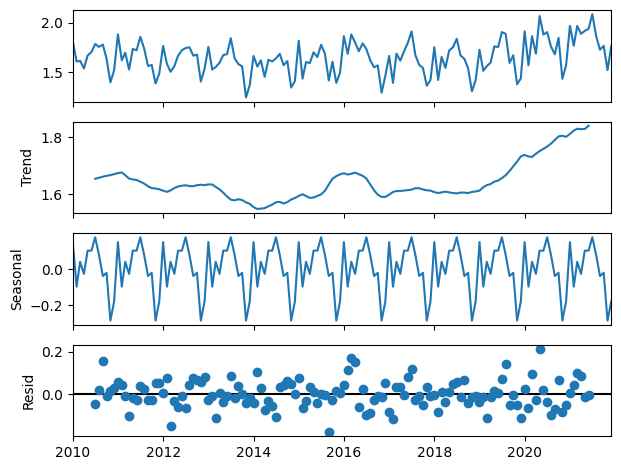

In [12]:
result = seasonal_decompose(time_series, model='aditive')
result.plot()
plt.show()

### Teste de Estacionariedade

In [13]:
# Função para testar a estacionaridade
def teste_adf(serie):
    result = adfuller(serie)
    print('ADF Estatíticas: %f' % result[0])
    print('Valor de P: %f' % result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

In [14]:
# Executa o teste de estacionaridade em 'taxa_media_yll'
X = time_series['taxa_media_yll']
teste_adf(X)

ADF Estatíticas: 0.236015
Valor de P: 0.974211
Valores Críticos:
	1%: -3.482
	5%: -2.884
	10%: -2.579
A série não é estacionária.


<Axes: xlabel='mes'>

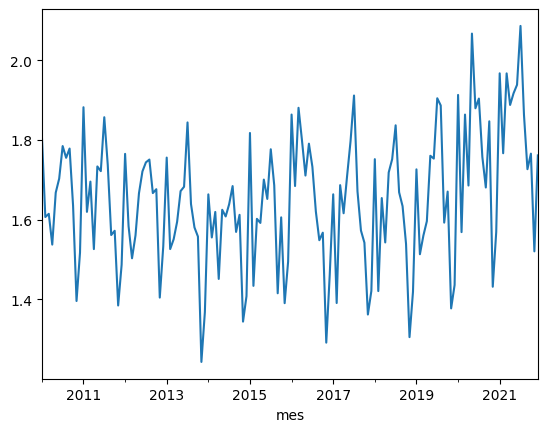

In [16]:
X.plot()

### Tornando a série estacionária com diferenciação simples

<Axes: xlabel='mes'>

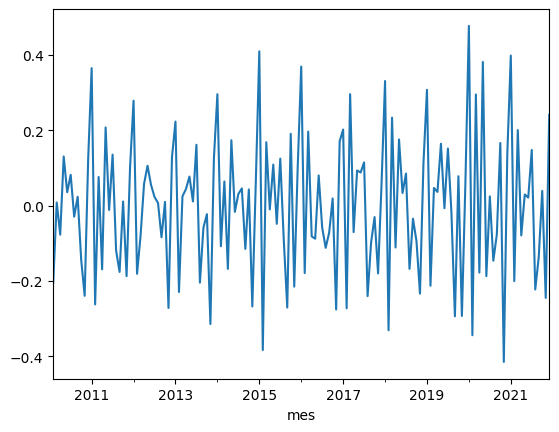

In [17]:
# Diferenciação simples
xdiff = X.diff().dropna()
xlabel='Data'
xdiff.plot()

In [18]:
# Verifica novamente a estacionaridade após a diferenciação
teste_adf(xdiff)

ADF Estatíticas: -4.678767
Valor de P: 0.000092
Valores Críticos:
	1%: -3.482
	5%: -2.884
	10%: -2.579
A série é estacionária.


In [20]:
xdiff

mes
2010-02-01   -0.205865
2010-03-01    0.008113
2010-04-01   -0.077275
2010-05-01    0.130273
2010-06-01    0.035351
                ...   
2021-08-01   -0.222733
2021-09-01   -0.136723
2021-10-01    0.039003
2021-11-01   -0.245214
2021-12-01    0.240849
Name: taxa_media_yll, Length: 143, dtype: float64

### Metodos Para Calcular o Theils U Coefficient

In [21]:
# Função para calcular o Theil’s U2
def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    # Cálculo do numerador (erro quadrático médio entre as previsões e os valores reais)
    numerator = np.sqrt(np.mean(np.square(y_pred - y_true)))
    
    # Cálculo do denominador (erro quadrático médio entre os valores reais deslocados)
    denominator = np.sqrt(np.mean(np.square(y_true[1:] - y_true[:-1])))
    
    # Cálculo do Theil’s U2
    theilU2 = numerator / denominator

    return theilU2

### ARIMA

In [22]:
X = time_series['taxa_media_yll'].loc[:'2019-12-31']

In [23]:
arima_model = auto_arima(X,
                         start_p=1, start_q=1,
                         max_p=6, max_q=6,
                         seasonal=False,  # Definindo como False para um modelo ARIMA
                         d=1, D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.712, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-95.761, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.670, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-97.488, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-95.508, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-99.413, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-97.690, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-97.433, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best mode

In [24]:
train = X.loc[:'2016-12-31']
test = X.loc['2017-01-01':'2019-12-31']

In [25]:
arima_model.fit(train)

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [26]:
future_forecast_arima = arima_model.predict(n_periods=36)

In [27]:
future_forecast_arima.index

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

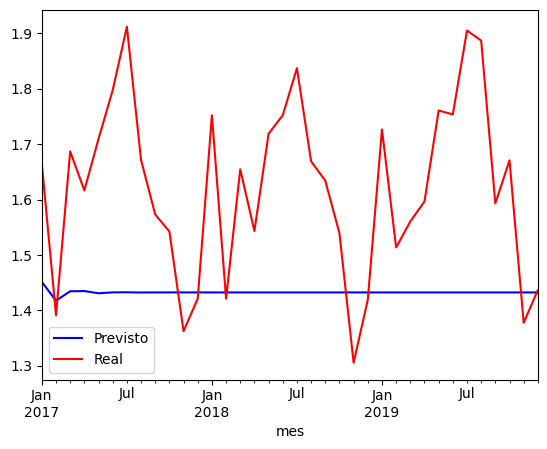

In [28]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
test.plot(marker='', color='red', label='Real', legend=True)

plt.show()

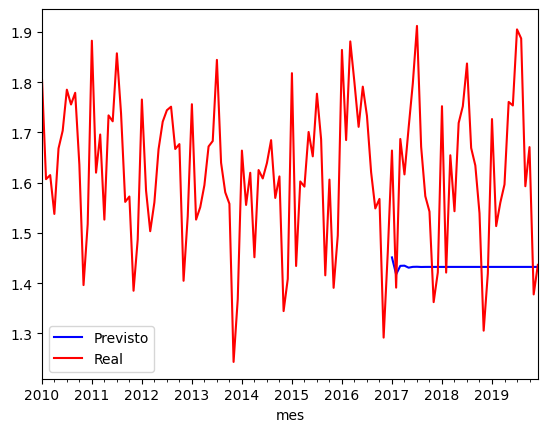

In [29]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.show()

In [30]:
# Parâmetros para calcular os intervalos de confiança
alpha_95 = 0.05 # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2 # Nível de significância para intervalo de confiança de 80%

# Valor crítico para distribuição normal padrão
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = future_forecast_arima
forecast_std = np.std(X)

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

In [31]:
future_forecast_arima

2017-01-01    1.451302
2017-02-01    1.417555
2017-03-01    1.434464
2017-04-01    1.434822
2017-05-01    1.430858
2017-06-01    1.432476
2017-07-01    1.432676
2017-08-01    1.432226
2017-09-01    1.432374
2017-10-01    1.432412
2017-11-01    1.432362
2017-12-01    1.432375
2018-01-01    1.432380
2018-02-01    1.432375
2018-03-01    1.432376
2018-04-01    1.432377
2018-05-01    1.432376
2018-06-01    1.432376
2018-07-01    1.432376
2018-08-01    1.432376
2018-09-01    1.432376
2018-10-01    1.432376
2018-11-01    1.432376
2018-12-01    1.432376
2019-01-01    1.432376
2019-02-01    1.432376
2019-03-01    1.432376
2019-04-01    1.432376
2019-05-01    1.432376
2019-06-01    1.432376
2019-07-01    1.432376
2019-08-01    1.432376
2019-09-01    1.432376
2019-10-01    1.432376
2019-11-01    1.432376
2019-12-01    1.432376
Freq: MS, dtype: float64

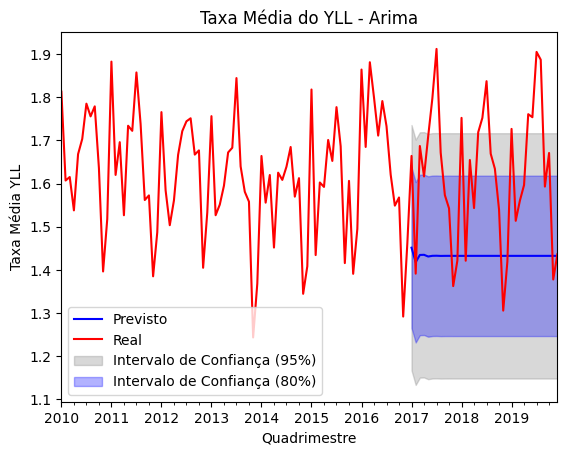

In [32]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.fill_between(future_forecast_arima.index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(future_forecast_arima.index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

plt.title('Taxa Média do YLL - Arima')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Quadrimestre')
plt.legend()
plt.show()

In [33]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test,future_forecast_arima)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test,future_forecast_arima)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mape = mean_absolute_percentage_error(test,future_forecast_arima)
print(f'MAPE: {mape}')

TU = theil_u2(test, future_forecast_arima)
print(f'TU: {TU}')

model_fit = arima_model.fit(train)
dw = durbin_watson(model_fit.resid())
print(f'Durbin-Watson: {dw}')

MAE: 0.20632782266038524
MSE: 0.060446610876855225
RMSE: 0.24585892474517826
MAPE: 0.12079152174953912
TU: 1.3824901251505959
Durbin-Watson: 1.5137937199819642


### SARIMA

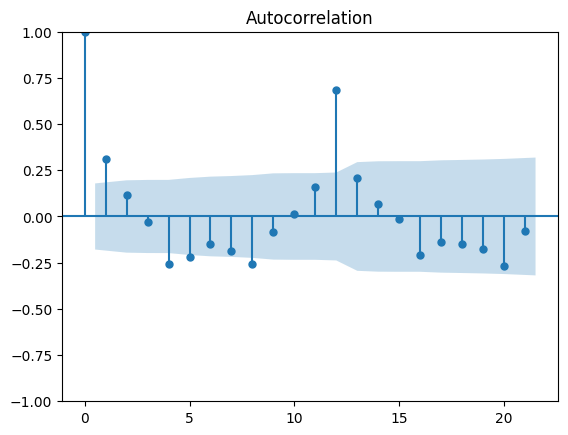

In [34]:
plot_acf(X)
plt.show()

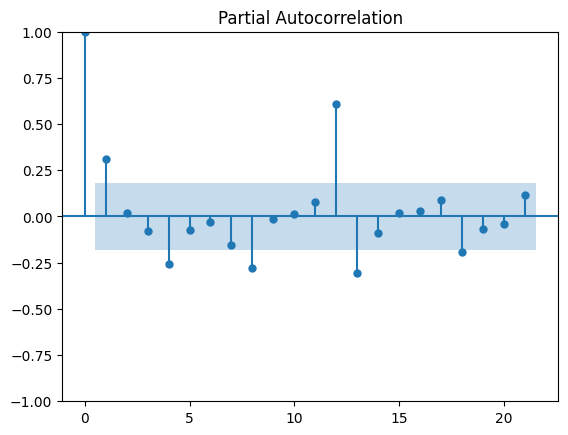

In [35]:
plot_pacf(X, method='ywm')
plt.show()

In [36]:
acorr_ljungbox(X, lags=[36])

,lb_stat,lb_pvalue
36,271.132949,7.540917e-38


In [37]:
sarima_model = auto_arima(
    X,
    start_p=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
    )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-231.600, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-162.977, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-213.444, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-228.261, Time=0.19 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-229.628, Time=0.44 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-229.623, Time=0.73 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-216.101, Time=0.17 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-223.500, Time=0.17 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-223.479, Time=0.52 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-224.262, Time=0.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-227.215, Time=0.23 sec
 ARIMA(2,1,0)(0,1,1)[12]          

In [38]:
print(sarima_model.aic())

-231.599776350142


In [39]:
train = X.loc[:'2016-12-31']
test = X.loc['2017-01-01':'2019-12-31']

In [40]:
sarima_model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [41]:
sarima_future_forecast = sarima_model.predict(n_periods=36)

In [42]:
sarima_future_forecast.index

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [43]:
sarima_future_forecast

2017-01-01    1.808136
2017-02-01    1.585996
2017-03-01    1.693119
2017-04-01    1.634215
2017-05-01    1.699006
2017-06-01    1.717405
2017-07-01    1.766472
2017-08-01    1.687782
2017-09-01    1.565919
2017-10-01    1.608698
2017-11-01    1.351392
2017-12-01    1.474354
2018-01-01    1.814681
2018-02-01    1.590285
2018-03-01    1.696507
2018-04-01    1.637242
2018-05-01    1.701889
2018-06-01    1.720231
2018-07-01    1.769275
2018-08-01    1.690576
2018-09-01    1.568709
2018-10-01    1.611486
2018-11-01    1.354180
2018-12-01    1.477141
2019-01-01    1.817469
2019-02-01    1.593072
2019-03-01    1.699294
2019-04-01    1.640029
2019-05-01    1.704676
2019-06-01    1.723018
2019-07-01    1.772062
2019-08-01    1.693363
2019-09-01    1.571496
2019-10-01    1.614273
2019-11-01    1.356967
2019-12-01    1.479929
Freq: MS, dtype: float64

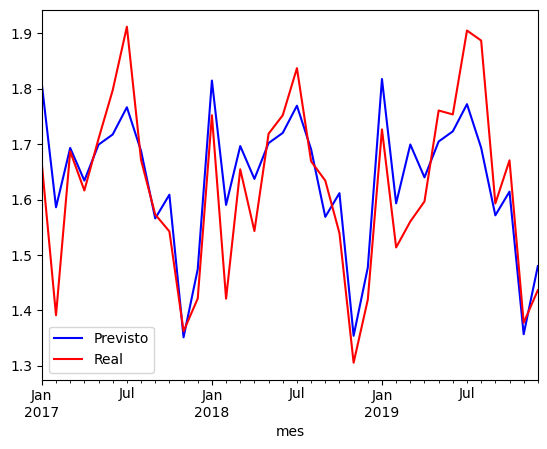

In [44]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
test.plot(marker='', color='red', label='Real', legend=True)

plt.show()

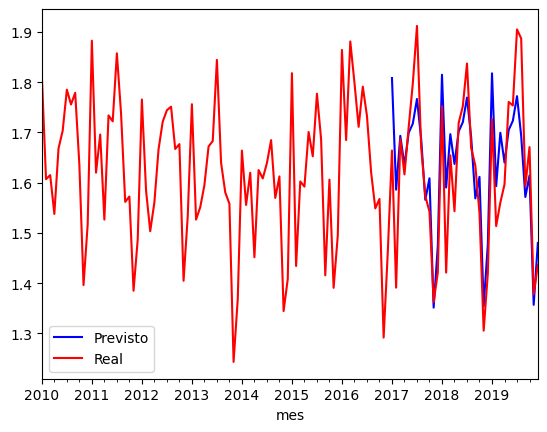

In [45]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.show()

In [46]:
# Parâmetros para calcular os intervalos de confiança
alpha_95 = 0.05 # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2 # Nível de significância para intervalo de confiança de 80%

# Valor crítico para distribuição normal padrão
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = sarima_future_forecast
forecast_std = np.std(X)

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

In [47]:
sarima_future_forecast.index

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

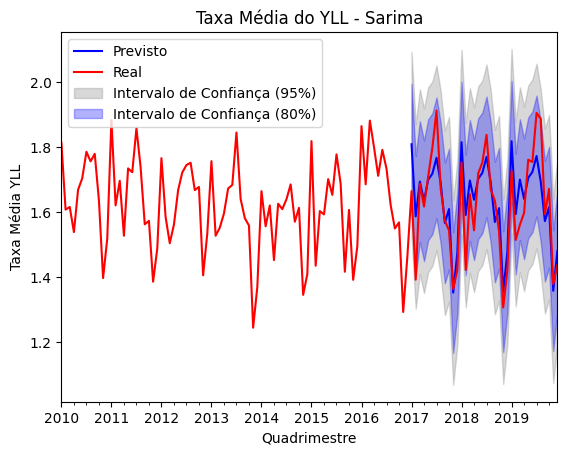

In [48]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.fill_between(sarima_future_forecast.index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(sarima_future_forecast.index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

plt.title('Taxa Média do YLL - Sarima')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Quadrimestre')
plt.legend()
plt.show()

In [49]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test,sarima_future_forecast)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test,sarima_future_forecast)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mape = mean_absolute_percentage_error(test,sarima_future_forecast)
print(f'MAPE: {mape}')

TU = theil_u2(test, sarima_future_forecast)
print(f'TU: {TU}')

model_fit = sarima_model.fit(train)
dw = durbin_watson(model_fit.resid())
print(f'Durbin-Watson: {dw}')

MAE: 0.06695272581407394
MSE: 0.007222005690923913
RMSE: 0.08498238459189006
MAPE: 0.04138967439214073
TU: 0.47786472519477774
Durbin-Watson: 1.4340140290736596
